In [1]:
!pip install --upgrade ultralytics
!pip install --upgrade -U ray[tune]
!apt-get install tree
!pip install -U ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 692.3 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.7/872.7 kB 6.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 MB 22.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: ray
    Found existing installation: ray 2.24.0
    Uninstalling ray-2.24.0:
      Successfully uninstalled ray-2.24.0
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 1.6 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 4.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling wi

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

%matplotlib inline

!wandb disabled # use if you have Weights and Biases installed

W&B disabled.


In [3]:
# define path to the folder with train, valid and test datasets
data_path='/kaggle/input/indoor-object-detection/'

In [4]:
# define class with basic model parameters
class CFG:
  DEBUG = False # Set to True to make quick experiments
  FRACTION = 0.05 if DEBUG else 1.0 # Specifies the fraction of the dataset to use for training. Allows for training on a subset of the full dataset, useful for experiments or when resources are limited.
  SEED = 42

  # classes
  CLASSES = ['door', 'openedDoor', 'cabinetDoor', 'refrigeratorDoor',
               'window', 'chair', 'table',
               'cabinet', 'sofa/couch', 'pole']
  NUM_CLASSES_TO_TRAIN = len(CLASSES)

  # training
  EPOCHS = 3 if DEBUG else 70 # 100
  BATCH_SIZE = 16 # 16

  BASE_MODEL='yolov9s' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
  BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
  EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

  OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
  LR = 0.001
  LR_FACTOR = 0.01 # Final learning rate as a fraction of the initial rate = (lr0 * lrf), used in conjunction with schedulers to adjust the learning rate over time.
  WEIGHT_DECAY = 5e-4 # L2 regularization term, penalizing large weights to prevent overfitting.
  DROPOUT = 0.0
  PATIENCE = 30
  PROFILE = False
  LABEL_SMOOTHING = 0.1

  # datasets
  TRAIN = 'train'
  VALID = 'valid'
  TEST = 'test'
  SPLITS = ['train','valid', 'test']

  # paths
  CUSTOM_DATASET_DIR=data_path
  OUTPUT_DIR='/kaggle/working/'

In [5]:
# visualize dataset folders structure
!tree {CFG.CUSTOM_DATASET_DIR} -L 2

/kaggle/input/indoor-object-detection/
|-- data.yaml
|-- test
|   |-- images
|   `-- labels
|-- train
|   |-- images
|   `-- labels
`-- valid
    |-- images
    `-- labels

9 directories, 1 file


In [6]:
# create data.yaml file in correspondance with YOLO format
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [7]:
# read yaml file
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
  with open(file_path, 'r') as file:
    try:
      data = yaml.safe_load(file)
      return data
    except yaml.YAMLError as e:
      print('Error while reading yaml file: ', e)
      return None

# print it with newlines
def print_yaml_data(data):
  formatted_yaml = yaml.dump(data, default_style=False)
  print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
  print_yaml_data(yaml_data)

names:
- door
- openedDoor
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- sofa/couch
- pole
nc: 10
test: /kaggle/input/indoor-object-detection/test
train: /kaggle/input/indoor-object-detection/train
val: /kaggle/input/indoor-object-detection/valid



In [8]:
# define function for image visualisation
def display_image(image, print_info=True, hide_axis=False):
  if isinstance(image, str):
    img = Image.open(image)
    plt.imshow(img)
  elif isinstance(image, np.ndarray):
    image=image[..., ::-1] # BGR to RGB
    img = Image.fromarray(image)
    plt.imshow(img)
  else:
    raise ValueError("Unsupported image format")

  if print_info:
    print('Type: ', type(img), '\n')
    print('Shape: ', np.array(img).shape, '\n')

  if hide_axis:
    plt.axis('off')
  plt.show()

# define function for extraction of image properties
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (766, 1024, 3) 



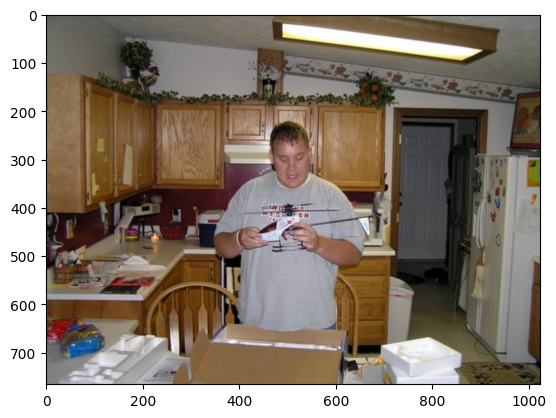

In [9]:
# visualize random image
example_image_path=CFG.CUSTOM_DATASET_DIR + 'train/images/007427672a3d5264.jpg'
display_image(example_image_path)

In [10]:
# get random image properties
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 1024, 'height': 766, 'channels': 3, 'dtype': dtype('uint8')}

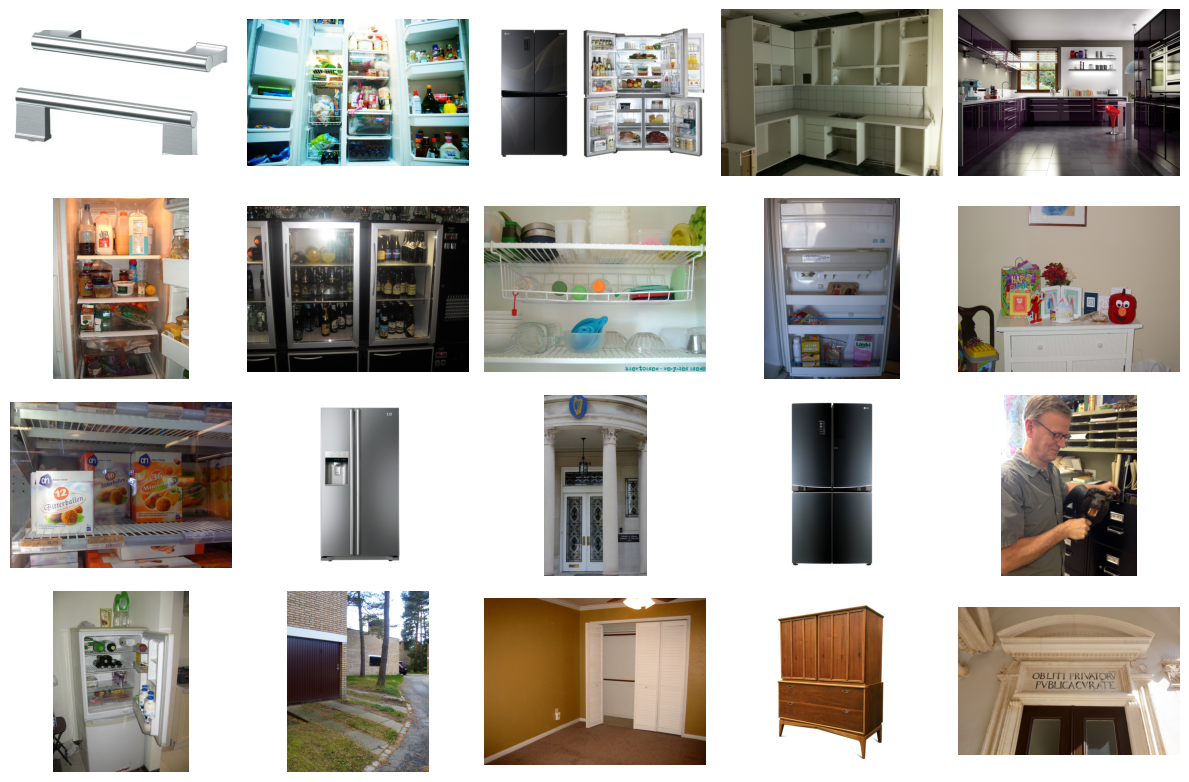

In [11]:
# visualize several random images
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

  random.seed(seed)

  # Get a list of image files in the folder
  image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

  # Ensure that we have at least num_images files to choose from
  if len(image_files) < num_images:
    raise ValueError("Not enough images in the folder")

  # Randomly select num_images image files
  selected_files = random.sample(image_files, num_images)

  # Create a subplot grid
  num_cols = 5
  num_rows = (num_images + num_cols - 1) // num_cols
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

  for i, file_name in enumerate(selected_files):
    # Open and display the image using PIL
    img = Image.open(os.path.join(folder_path, file_name))

    if num_rows == 1:
      ax = axes[i % num_cols]
    else:
      ax = axes[i // num_cols, i % num_cols]

    ax.imshow(img)
    ax.axis('off')
    # ax.set_title(file_name)

  # Remove empty subplots
  for i in range(num_images, num_rows * num_cols):
    if num_rows == 1:
      fig.delaxes(axes[i % num_cols])
    else:
      fig.delaxes(axes[i // num_cols, i % num_cols])

  plt.tight_layout()
  plt.show()

folder_path = CFG.CUSTOM_DATASET_DIR + f'{CFG.TRAIN}/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

In [12]:
# get basic dataset statistics
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in CFG.SPLITS:
  class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

  path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

  for file in os.listdir(path):
    with open(os.path.join(path,file)) as f:
      lines=f.readlines()

      for cls in set([line[0] for line in lines]):
        class_count[class_idx[cls]]+=1

  data_len[mode] = len(os.listdir(path))
  class_stat[mode] = class_count

  class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None):
  display(dataset_stats_df)

,Mode,door,openedDoor,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,sofa/couch,pole,Data_Volume
0,train,309,448,332,187,105,165,138,22,68,14,1008
1,valid,63,99,85,39,24,30,28,1,13,4,230
2,test,25,42,1,49,38,41,44,31,18,3,104


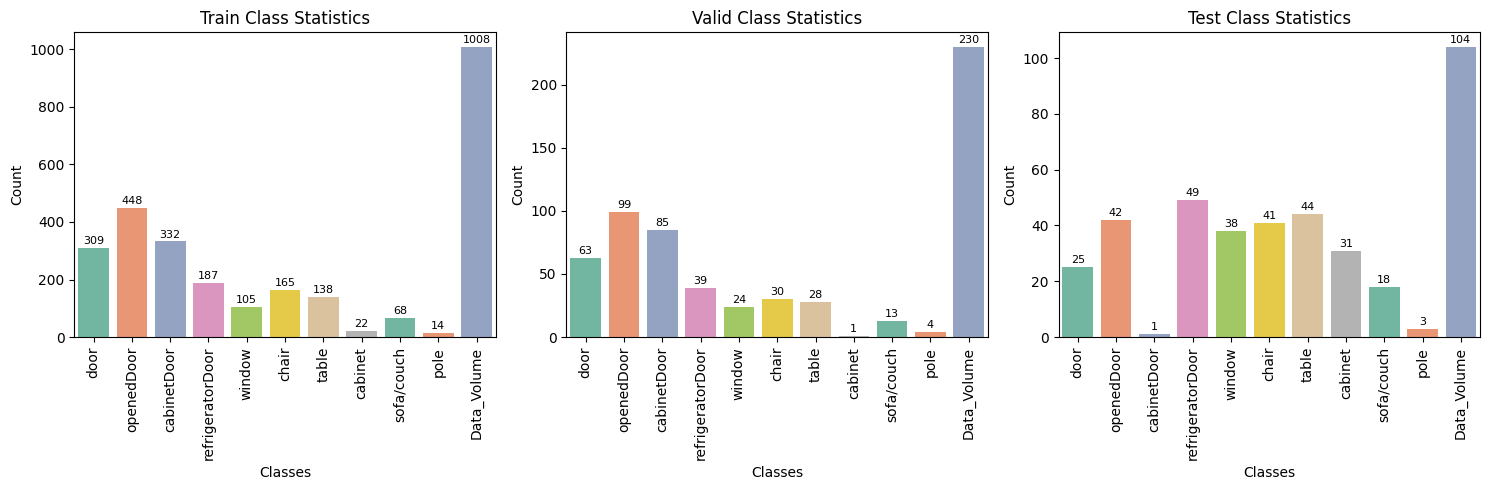

In [13]:
# classes distribution visualisation
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

We have a disbalance in classes, we should take it into account while choosing model estimation metrics.

100%|██████████| 14.7M/14.7M [00:00<00:00, 125MB/s] 



WARNING ⚠️ imgsz=[766, 1024] must be multiple of max stride 32, updating to [768, 1024]
image 1/1 /kaggle/input/indoor-object-detection/train/images/007427672a3d5264.jpg: 768x1024 1 person, 2 chairs, 1 potted plant, 1 dining table, 1 refrigerator, 32.3ms
Speed: 8.9ms preprocess, 32.3ms inference, 265.8ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels
Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (766, 1024, 3) 



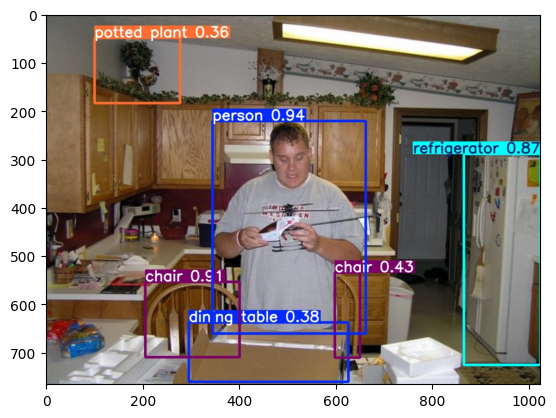

In [14]:
# create test YOLOv9 model and run it on test dataset
model_test=YOLO(CFG.BASE_MODEL_WEIGHTS)
results = model_test.predict(
    source = example_image_path,
#     classes = [x for x in range(0,10)],
    conf = 0.3,
    device = None,
    imgsz = (img_properties['height'], img_properties['width']),
    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

We see that our model have сщккуседн detected "chair" class from our classes list

In [15]:
%%time

# model creation
model = YOLO(CFG.BASE_MODEL_WEIGHTS)


# train model
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    task = 'detect',
    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = [0], #  [0,1]
#     device = None, # CPU run
    verbose = False,
)

Ultralytics YOLOv8.2.94 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov9s.pt, data=/kaggle/working/data.yaml, epochs=70, time=None, patience=30, batch=16, imgsz=(766, 1024), save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov9s_ppe_css_70_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

100%|██████████| 755k/755k [00:00<00:00, 14.3MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     31104  ultralytics.nn.modules.block.ELAN1           [64, 64, 64, 32]              
  3                  -1  1     73984  ultralytics.nn.modules.block.AConv           [64, 128]                     
  4                  -1  1    258432  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 128, 128, 64, 3]        
  5                  -1  1    221568  ultralytics.nn.modules.block.AConv           [128, 192]                    
  6                  -1  1    579648  ultralytics.nn.modules.block.RepNCSPELAN4    [192, 192, 192, 96, 3]        
  7                  -1  1    442880  ultralytic

100%|██████████| 6.25M/6.25M [00:00<00:00, 77.3MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=1024'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/indoor-object-detection/train/labels... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:04<00:00, 249.14it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/indoor-object-detection/valid/labels... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<00:00, 258.51it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/valid is not writeable, cache not saved.


Plotting labels to runs/detect/yolov9s_ppe_css_70_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/yolov9s_ppe_css_70_epochs
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      12.7G      1.675      3.497       1.73         25       1024: 100%|██████████| 64/64 [00:58<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]

                   all        230       1289      0.538      0.265      0.232      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      12.7G      1.498      2.072       1.54         45       1024: 100%|██████████| 64/64 [00:56<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]

                   all        230       1289      0.509      0.258      0.195      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      12.6G      1.479      1.918      1.545         34       1024: 100%|██████████| 64/64 [00:55<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        230       1289      0.515      0.227      0.243      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      12.8G      1.502      1.883      1.559        110       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]

                   all        230       1289      0.337      0.246      0.215      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      12.5G      1.471      1.766       1.55         32       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]

                   all        230       1289      0.536      0.247      0.209      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      12.6G      1.463      1.769       1.54         29       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        230       1289      0.344      0.305       0.23      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      12.7G      1.448      1.637      1.528         33       1024: 100%|██████████| 64/64 [00:55<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.574      0.266      0.231      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      12.8G      1.445      1.633      1.517         89       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.537       0.26      0.231       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      12.6G      1.416      1.555      1.499         40       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.558      0.283      0.261      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      12.4G       1.38      1.511      1.507         43       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        230       1289      0.697      0.261      0.289      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      12.6G      1.387      1.506      1.501         66       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.599      0.261      0.282      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      12.6G      1.369       1.43      1.471         26       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        230       1289      0.653       0.29      0.296      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      12.7G      1.343      1.391      1.449         53       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        230       1289      0.415       0.33      0.302      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      12.6G      1.323      1.331      1.448         23       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        230       1289      0.301      0.361      0.317      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      12.6G      1.333      1.354      1.457         37       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        230       1289      0.424      0.357      0.333      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      12.7G      1.343      1.335      1.465         30       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.419      0.334      0.326      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      12.7G      1.303      1.257      1.433         21       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.523      0.303      0.314      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      12.7G      1.304      1.273      1.441         15       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.565       0.29      0.319      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      12.5G      1.312       1.26       1.45         23       1024: 100%|██████████| 64/64 [00:55<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.621      0.331       0.33      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      12.6G      1.275      1.207      1.423         45       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        230       1289      0.592      0.374      0.352      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      12.4G      1.275      1.166      1.404         41       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.486      0.342      0.355      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      13.2G      1.287      1.185      1.415         45       1024: 100%|██████████| 64/64 [00:55<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.437      0.363      0.357      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      12.7G      1.248       1.13      1.395         53       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.432      0.321      0.325      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      12.7G      1.243      1.122      1.386         36       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.582       0.33      0.351      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      13.2G      1.234      1.094      1.386         28       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.356      0.459      0.366       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      12.7G      1.217      1.051      1.369         50       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.464      0.329       0.34      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      12.7G      1.209      1.048      1.372         54       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.528      0.372      0.382      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      12.6G      1.184      1.023      1.356         26       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.427      0.408      0.374      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      12.8G      1.178     0.9847      1.334         26       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.664      0.348      0.378      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      12.7G      1.176     0.9937      1.354         80       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.432      0.452      0.374      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      12.2G      1.188     0.9789      1.347         43       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]

                   all        230       1289      0.407      0.381      0.366      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      12.8G      1.172     0.9744      1.345         90       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.476      0.349      0.389      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      12.6G      1.132     0.8862      1.308         92       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.351      0.512      0.411      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      12.6G      1.113     0.8871      1.295         37       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]

                   all        230       1289      0.382      0.437      0.386      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      12.6G      1.138      0.907      1.307         32       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]

                   all        230       1289      0.503       0.36      0.398       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      12.7G      1.102     0.8761      1.293         34       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.349      0.514      0.397      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      12.8G      1.102     0.8462      1.279         34       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        230       1289      0.581      0.407      0.428      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      12.6G      1.098     0.8488      1.288         19       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.468      0.356      0.379      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      12.7G      1.101     0.8322      1.283         66       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.491      0.499      0.419      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      12.8G      1.076     0.8102      1.273         42       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.385      0.394      0.367      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      12.7G      1.063     0.8057      1.261         39       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.371      0.364      0.378       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      12.7G      1.068     0.8201      1.269         37       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289       0.46      0.374      0.388      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      12.7G      1.047     0.7898      1.255          7       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.548      0.376      0.396       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      12.7G      1.042     0.7571      1.253         58       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.409      0.462      0.395       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      12.6G      1.046     0.7652      1.259         33       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.586      0.415      0.471      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      12.7G      1.028     0.7413      1.238         28       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.352      0.555      0.408      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      12.7G       1.02     0.7564      1.254         42       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.495      0.492      0.417      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      12.2G     0.9912     0.6986      1.226         24       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

                   all        230       1289      0.505      0.482      0.486      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      12.6G     0.9846     0.6929      1.204         35       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        230       1289      0.608      0.394      0.472      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      12.7G     0.9877     0.6949      1.207         31       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        230       1289      0.536      0.389       0.41      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      12.3G     0.9733     0.6847      1.196         12       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.342      0.421      0.408       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      12.4G     0.9672     0.6783      1.202         16       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289       0.51       0.46      0.486      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      13.1G     0.9454     0.6458      1.195         44       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        230       1289      0.366      0.495        0.4       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      12.7G     0.9411     0.6489      1.176         31       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        230       1289      0.522      0.404      0.441      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      12.7G     0.9362     0.6363      1.179         18       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        230       1289      0.379      0.492      0.431      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      12.3G     0.9286     0.6073      1.166         48       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        230       1289      0.373      0.496      0.415      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      12.7G     0.9128     0.6124      1.164         51       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.422      0.539      0.452      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      12.7G     0.9127     0.6129       1.16         86       1024: 100%|██████████| 64/64 [00:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.389      0.578      0.434      0.272


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      12.8G     0.9287     0.5748      1.177         25       1024: 100%|██████████| 64/64 [00:56<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        230       1289      0.551      0.406      0.476      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      12.8G      0.879     0.5123      1.141         16       1024: 100%|██████████| 64/64 [00:55<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        230       1289      0.433      0.501      0.491      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      12.8G     0.8798     0.5013      1.143         31       1024: 100%|██████████| 64/64 [00:54<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.443      0.531       0.49      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      12.8G     0.8664     0.4843      1.137          6       1024: 100%|██████████| 64/64 [00:54<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        230       1289      0.425      0.539      0.491      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      12.7G     0.8595      0.476       1.14         11       1024: 100%|██████████| 64/64 [00:54<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.424        0.5      0.436      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      12.6G      0.842     0.4696      1.129         10       1024: 100%|██████████| 64/64 [00:54<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.461      0.502      0.422      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      12.8G     0.8276     0.4609      1.105         22       1024: 100%|██████████| 64/64 [00:54<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.494      0.462      0.443      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      12.7G     0.8268     0.4518      1.105         64       1024: 100%|██████████| 64/64 [00:54<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        230       1289      0.443      0.503      0.446       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      12.8G     0.8302     0.4539       1.11         27       1024: 100%|██████████| 64/64 [00:54<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        230       1289      0.431      0.492      0.451      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      12.8G     0.8036     0.4412      1.095         14       1024: 100%|██████████| 64/64 [00:54<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        230       1289      0.457      0.494      0.451      0.294



70 epochs completed in 1.219 hours.
Optimizer stripped from runs/detect/yolov9s_ppe_css_70_epochs/weights/last.pt, 15.3MB
Optimizer stripped from runs/detect/yolov9s_ppe_css_70_epochs/weights/best.pt, 15.3MB

Validating runs/detect/yolov9s_ppe_css_70_epochs/weights/best.pt...
Ultralytics YOLOv8.2.94 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9s summary (fused): 486 layers, 7,170,958 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


                   all        230       1289      0.453       0.48      0.492      0.322
Speed: 0.4ms preprocess, 12.8ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/detect/yolov9s_ppe_css_70_epochs
CPU times: user 1h 35s, sys: 15min 20s, total: 1h 15min 56s
Wall time: 1h 13min 58s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79f601d9c310>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [16]:
# export the model to store weights of trained model
model.export(
    format = 'onnx',# openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.2.94 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ imgsz=[766, 1024] must be multiple of max stride 32, updating to [768, 1024]
YOLOv9s summary (fused): 486 layers, 7,170,958 parameters, 0 gradients, 26.7 GFLOPs

PyTorch: starting from 'runs/detect/yolov9s_ppe_css_70_epochs/weights/best.pt' with input shape (1, 3, 768, 1024) BCHW and output shape(s) (1, 14, 16128) (14.6 MB)

ONNX: starting export with onnx 1.16.2 opset 19...
ONNX: export success ✅ 2.8s, saved as 'runs/detect/yolov9s_ppe_css_70_epochs/weights/best.onnx' (27.8 MB)

Export complete (6.6s)
Results saved to /kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9s_ppe_css_70_epochs/weights/best.onnx imgsz=768,1024  
Validate:        yolo val task=detect model=runs/detect/yolov9s_ppe_css_70_epochs/weights/best.onnx imgsz=768,1024 data=/kaggle/working/data.yaml  WARNING ⚠️ non-PyTorch val requires square images, 'imgs

'runs/detect/yolov9s_ppe_css_70_epochs/weights/best.onnx'

In [17]:
# create list with stored images that visualize our model result metrics
results_paths = [
    i for i in glob.glob(f"{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png")+
    glob.glob(f"{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg")
    if 'batch' not in i
]

results_paths

['/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/R_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/confusion_matrix.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/results.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/F1_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/P_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/confusion_matrix_normalized.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/PR_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/labels.jpg',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/labels_correlogram.jpg']

/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/F1_curve.png


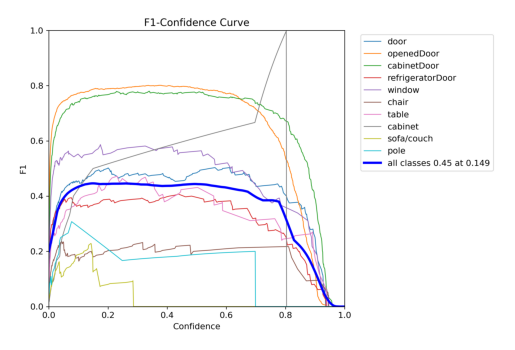



/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/PR_curve.png


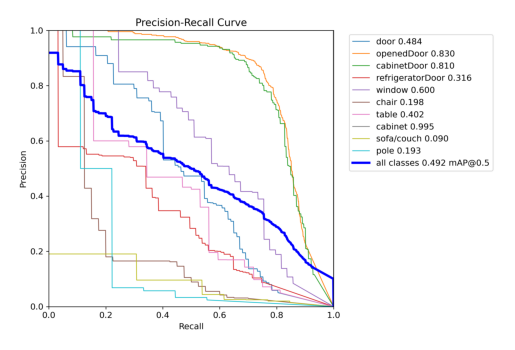



/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/P_curve.png


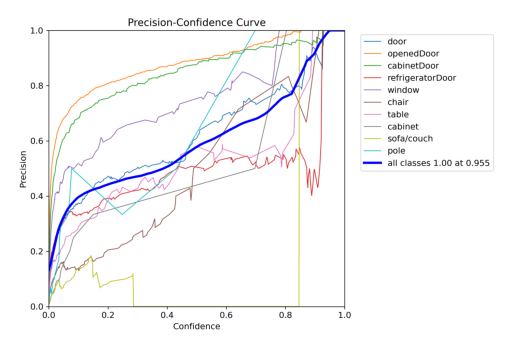



/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/R_curve.png


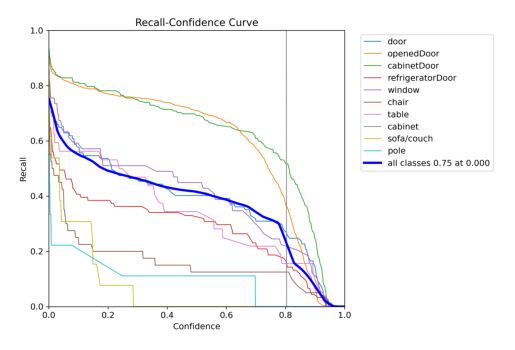



/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/confusion_matrix.png


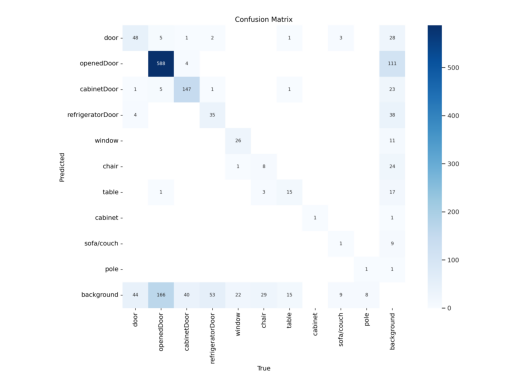



/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/confusion_matrix_normalized.png


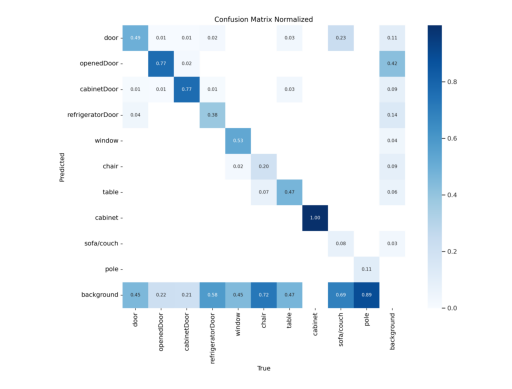



/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/labels.jpg


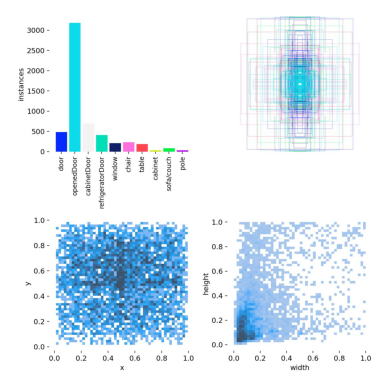



/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/labels_correlogram.jpg


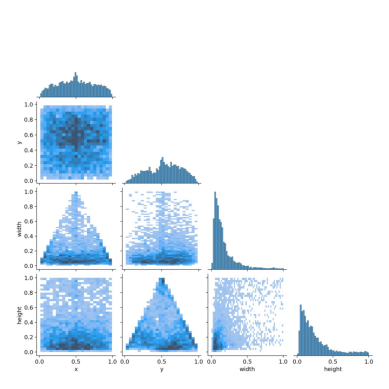



/kaggle/working/runs/detect/yolov9s_ppe_css_70_epochs/results.png


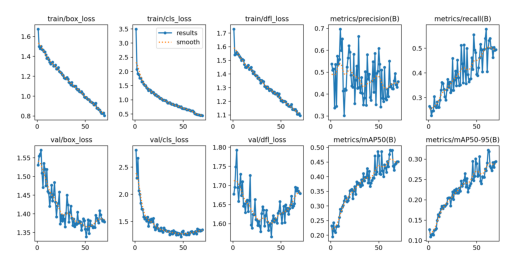

In [18]:
# visualize model results and analize them
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info=False,hide_axis=True)
    print('\n')

**Analysis of Results**

Picture 1: Our model achieves a maximum F1 score of 45% at a confidence threshold of 0.15. This result is suboptimal, indicating the need for further model improvements.

Picture 2: The mean average precision (mAP) at a threshold of 0.5 is 0.5, meaning the model correctly identifies half of the presented classes. However, the mAP@0.5 for the classes "pole," "chair," and "sofa/couch" is notably low. To improve the model's performance, it is recommended to increase the number of images containing these classes. On the other hand, the highest mAP values are observed for the classes "openedDoor," "cabinetDoor," and "cabinet," suggesting that both Precision and Recall are high for these classes.

Pictures 5 and 6: The confusion matrix reveals that the model often fails to detect the classes "pole," "chair," and "sofa/couch." Additionally, the "door" class is frequently misclassified as other classes.

Picture 9: The loss function decreases across all metrics for both the training and validation datasets. However, after 50 epochs, we observe an increase in Distribution Focal Loss (YOLO) for the validation set, which may indicate model overfitting. Precision fluctuates between 45% and 50%, while recall reaches 50%, implying that the model misses about half of the objects and requires further improvement. The mAP@50 is around 45%, while mAP@50-95 is only 28%, highlighting the need for optimization.

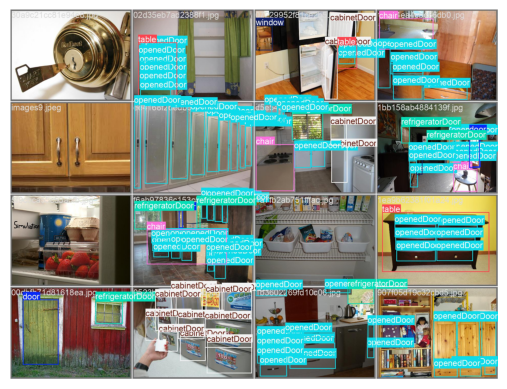

In [19]:
# visualize detection results 
validation_results_paths = [
    i for i in 
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    display_image(val_img_path, print_info = False, hide_axis = True)

We observe that our model indicates many similar objects as "openedDoor" or "cabinetDoor" classes. It definitely needs improvements.
**Possible improvements:**

*Tune Hyperparameters:* Experiment with different learning rates, batch sizes, and optimization techniques to stabilize training and improve precision and recall.

*Augment Data:* Increase the number of images containing these underperforming classes. Use data augmentation techniques such as rotation, scaling, or flipping to artificially expand the dataset for these classes.

*Class Weighting:* Assign higher weights to underrepresented classes in the loss function to reduce bias towards overrepresented classes.